# 01 - Classificação com Validação Cruzada Estratificada

Este notebook realiza o pré-processamento, separação de atributos/rótulos e avaliação de três algoritmos supervisionados:
- Árvore de Decisão (Random Forest)
- K-NN (K-Nearest Neighbors)
- MLP (Multi-Layer Perceptron)

A avaliação utiliza F1-score e matriz de confusão via validação cruzada estratificada k-fold, com `random_state` fixo para reprodutibilidade.

Observação: Ajuste o caminho do arquivo da base de dados na seção de carregamento.


In [1]:
import pandas as pd

# Configurações gerais
RANDOM_STATE = 42
N_JOBS = -1
N_SPLITS = 5  # k-fold
TEST_SIZE = 0.2

# Exibição de opções do pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 120)


In [ ]:
# Imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import (
    StratifiedKFold, 
    cross_validate, 
    cross_val_predict, 
    cross_val_score,
    train_test_split
)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay, make_scorer

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
import pandas as pd
from sklearn.model_selection import StratifiedGroupKFold, cross_val_score
from sklearn.metrics import make_scorer, f1_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import numpy as np
# Importar bibliotecas necessárias para plotar a matriz de confusão
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

## Carregamento de dados

Substitua `data/arquivo.csv` pelo caminho real. O rótulo (target) deve estar em uma coluna, por exemplo `target`. Se a base tiver valores ausentes, faremos tratamento na etapa de pré-processamento.


## Pré-processamento

- Identificação de colunas numéricas e categóricas
- Tratamento de valores ausentes
- Padronização de numéricas e One-Hot em categóricas
- Separação de `X` e `y`


In [37]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

### Montando o dataframe

As partes com menor visibilidade e que no geral não são tão importantes para libras serão retiradas do df.

A visibilidade a partir do keypoint 25 (dos Joelhos para baixo) é muito baixa e também não é tão importante na língua de sinais.

Desconsiderei os quadris e o rosto também


In [137]:

sinais = pd.read_csv('../data/Sinais/sinais.csv')
print(sinais.shape)
print(sinais.head())

def extrair_metricas_do_arquivo(caminho_arquivo):
    # Carregando o arquivo JSON
    sinal = pd.read_json(caminho_arquivo)
    frames = sinal['frames']
    dados_keypoints = []

    # --- Normalização: pega keypoint id=0 do frame 0 como referência ---
    ref_x, ref_y, ref_z = None, None, None
    for keypoint in frames[0]['keypoints']:
        if keypoint['id'] == 0:
            ref_x, ref_y, ref_z = keypoint['x'], keypoint['y'], keypoint['z']
            break

    if ref_x is None:
        raise ValueError("Frame 0 não contém keypoint id=0!")

    # Iterando por todos os frames
    for frame_idx, frame_data in enumerate(frames):
        for keypoint in frame_data['keypoints']:
            if 11 <= keypoint['id'] <= 22:
                dados_keypoints.append({
                    'frame': frame_idx,
                    'id': keypoint['id'],
                    # Centralização: subtrai o ponto de referência
                    'x': keypoint['x'] - ref_x,
                    'y': keypoint['y'] - ref_y,
                    'z': keypoint['z'] - ref_z,
                    'visibility': keypoint['visibility']
                })

    # Convertendo para DataFrame
    df_keypoints = pd.DataFrame(dados_keypoints)

    # Calculando métricas para cada ID e cada atributo
    metricas = df_keypoints.groupby('id').agg({
        'x': ['mean', 'std', 'min', 'max'],
        'y': ['mean', 'std', 'min', 'max'],
        'z': ['mean', 'std', 'min', 'max'],
        'visibility': ['mean', 'std', 'min', 'max']
    })

    # Achatando colunas
    metricas.columns = ['_'.join(col).strip() for col in metricas.columns.values]
    metricas = metricas.reset_index()

    # Criando dicionário com todas as métricas
    metricas_dict = {}
    for _, row in metricas.iterrows():
        id_keypoint = int(row['id'])
        for col in metricas.columns:
            if col != 'id':
                metricas_dict[f'id_{id_keypoint}_{col}'] = row[col]

    return metricas_dict


# --- Pipeline de extração de todos os arquivos ---
resultados = pd.DataFrame()

for idx, row in sinais.iterrows():
    caminho_arquivo = f'../data/Sinais/Sinais/{row["file_name"]}'
    try:
        metricas_arquivo = extrair_metricas_do_arquivo(caminho_arquivo)
        temp_df = pd.DataFrame([{**row, **metricas_arquivo}])
        resultados = pd.concat([resultados, temp_df], ignore_index=True)

        if idx % 10 == 0:
            print(f"Processados {idx+1} arquivos de {len(sinais)}")

    except Exception as e:
        print(f"Erro ao processar {row['file_name']}: {e}")


(2502, 7)
           file_name  width  height  duration_sec  num_frames   sinal interprete
0  Adição_AP_10.json    738    1008      4.533333         136  Adição    Alexson
1   Adição_AP_1.json    774    1006      4.766667         143  Adição    Alexson
2   Adição_AP_2.json    760    1002      4.433333         133  Adição    Alexson
3   Adição_AP_3.json    762    1000      4.933333         148  Adição    Alexson
4   Adição_AP_4.json    764    1004      4.600000         138  Adição    Alexson
Processados 1 arquivos de 2502
Processados 11 arquivos de 2502
Processados 21 arquivos de 2502
Processados 31 arquivos de 2502
Processados 41 arquivos de 2502
Processados 51 arquivos de 2502
Processados 61 arquivos de 2502
Processados 71 arquivos de 2502
Processados 81 arquivos de 2502
Processados 91 arquivos de 2502
Processados 101 arquivos de 2502
Processados 111 arquivos de 2502
Processados 121 arquivos de 2502
Processados 131 arquivos de 2502
Processados 141 arquivos de 2502
Processados 151 arqu

/var/folders/ns/qqkzf_x52rqdpshm0vpl205r0000gn/T/ipykernel_61239/3720336030.py:7: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  sinal = pd.read_json(caminho_arquivo)


Processados 601 arquivos de 2502
Processados 611 arquivos de 2502
Processados 621 arquivos de 2502
Processados 631 arquivos de 2502
Processados 641 arquivos de 2502
Processados 651 arquivos de 2502
Processados 661 arquivos de 2502
Processados 671 arquivos de 2502
Processados 681 arquivos de 2502
Processados 691 arquivos de 2502
Processados 701 arquivos de 2502
Processados 711 arquivos de 2502
Processados 721 arquivos de 2502
Processados 731 arquivos de 2502
Processados 741 arquivos de 2502
Processados 751 arquivos de 2502
Processados 761 arquivos de 2502
Processados 771 arquivos de 2502
Processados 781 arquivos de 2502
Processados 791 arquivos de 2502
Processados 801 arquivos de 2502
Processados 811 arquivos de 2502
Processados 821 arquivos de 2502
Processados 831 arquivos de 2502
Processados 841 arquivos de 2502
Processados 851 arquivos de 2502
Processados 861 arquivos de 2502
Processados 871 arquivos de 2502
Processados 881 arquivos de 2502
Processados 891 arquivos de 2502
Processado

In [138]:
resultados.head()


,file_name,width,height,duration_sec,num_frames,sinal,interprete,id_11_x_mean,id_11_x_std,id_11_x_min,id_11_x_max,id_11_y_mean,id_11_y_std,id_11_y_min,id_11_y_max,id_11_z_mean,id_11_z_std,id_11_z_min,id_11_z_max,id_11_visibility_mean,id_11_visibility_std,id_11_visibility_min,id_11_visibility_max,id_12_x_mean,id_12_x_std,id_12_x_min,id_12_x_max,id_12_y_mean,id_12_y_std,id_12_y_min,id_12_y_max,id_12_z_mean,id_12_z_std,id_12_z_min,id_12_z_max,id_12_visibility_mean,id_12_visibility_std,id_12_visibility_min,id_12_visibility_max,id_13_x_mean,id_13_x_std,id_13_x_min,id_13_x_max,id_13_y_mean,id_13_y_std,id_13_y_min,id_13_y_max,id_13_z_mean,id_13_z_std,id_13_z_min,id_13_z_max,id_13_visibility_mean,id_13_visibility_std,id_13_visibility_min,id_13_visibility_max,id_14_x_mean,id_14_x_std,id_14_x_min,id_14_x_max,id_14_y_mean,id_14_y_std,id_14_y_min,id_14_y_max,id_14_z_mean,id_14_z_std,id_14_z_min,id_14_z_max,id_14_visibility_mean,id_14_visibility_std,id_14_visibility_min,id_14_visibility_max,id_15_x_mean,id_15_x_std,id_15_x_min,id_15_x_max,id_15_y_mean,id_15_y_std,id_15_y_min,id_15_y_max,id_15_z_mean,id_15_z_std,id_15_z_min,id_15_z_max,id_15_visibility_mean,id_15_visibility_std,id_15_visibility_min,id_15_visibility_max,id_16_x_mean,id_16_x_std,id_16_x_min,id_16_x_max,id_16_y_mean,id_16_y_std,id_16_y_min,id_16_y_max,id_16_z_mean,id_16_z_std,id_16_z_min,id_16_z_max,id_16_visibility_mean,id_16_visibility_std,id_16_visibility_min,id_16_visibility_max,id_17_x_mean,id_17_x_std,id_17_x_min,id_17_x_max,id_17_y_mean,id_17_y_std,id_17_y_min,id_17_y_max,id_17_z_mean,id_17_z_std,id_17_z_min,id_17_z_max,id_17_visibility_mean,id_17_visibility_std,id_17_visibility_min,id_17_visibility_max,id_18_x_mean,id_18_x_std,id_18_x_min,id_18_x_max,id_18_y_mean,id_18_y_std,id_18_y_min,id_18_y_max,id_18_z_mean,id_18_z_std,id_18_z_min,id_18_z_max,id_18_visibility_mean,id_18_visibility_std,id_18_visibility_min,id_18_visibility_max,id_19_x_mean,id_19_x_std,id_19_x_min,id_19_x_max,id_19_y_mean,id_19_y_std,id_19_y_min,id_19_y_max,id_19_z_mean,id_19_z_std,id_19_z_min,id_19_z_max,id_19_visibility_mean,id_19_visibility_std,id_19_visibility_min,id_19_visibility_max,id_20_x_mean,id_20_x_std,id_20_x_min,id_20_x_max,id_20_y_mean,id_20_y_std,id_20_y_min,id_20_y_max,id_20_z_mean,id_20_z_std,id_20_z_min,id_20_z_max,id_20_visibility_mean,id_20_visibility_std,id_20_visibility_min,id_20_visibility_max,id_21_x_mean,id_21_x_std,id_21_x_min,id_21_x_max,id_21_y_mean,id_21_y_std,id_21_y_min,id_21_y_max,id_21_z_mean,id_21_z_std,id_21_z_min,id_21_z_max,id_21_visibility_mean,id_21_visibility_std,id_21_visibility_min,id_21_visibility_max,id_22_x_mean,id_22_x_std,id_22_x_min,id_22_x_max,id_22_y_mean,id_22_y_std,id_22_y_min,id_22_y_max,id_22_z_mean,id_22_z_std,id_22_z_min,id_22_z_max,id_22_visibility_mean,id_22_visibility_std,id_22_visibility_min,id_22_visibility_max
0,Adição_AP_10.json,738,1008,4.533333,136,Adição,Alexson,183.845588,2.511835,180.0,190.0,198.169118,4.561603,189.0,203.0,1.026765,0.036654,0.84,1.09,1.0,0.0,1.0,1.0,-156.220588,5.778237,-163.0,-138.0,192.198529,5.374590,180.0,199.0,1.131250,0.136650,0.90,1.39,1.0,0.0,1.0,1.0,239.051471,20.950142,199.0,261.0,460.316176,5.452423,454.0,472.0,0.840809,0.269147,0.37,1.11,1.000000,0.000000,1.00,1.0,-271.669118,65.398387,-369.0,-213.0,406.279412,63.158905,298.0,461.0,0.855515,0.211509,0.48,1.08,1.000000,0.000000,1.00,1.0,64.242647,37.984109,7.0,98.0,505.735294,137.498134,272.0,619.0,0.195735,0.342309,-0.52,0.62,0.986985,0.009453,0.97,1.0,-116.463235,64.089163,-226.0,-57.0,454.566176,188.854547,165.0,624.0,0.100882,0.415668,-0.71,0.56,0.982868,0.011149,0.97,1.0,16.102941,41.610234,-48.0,53.0,539.911765,187.441664,224.0,689.0,0.010368,0.340042,-0.71,0.48,0.964191,0.021101,0.90,0.99,-66.514706,58.612347,-169.0,-11.0,491.823529,227.956100,140.0,692.0,-0.071103,0.425130,-0.91,0.41,0.951029,0.017139,0.92,0.98,4.889706,32.517727,-48.0,37.0,508.985294,186.493252,197.0,658.0,0.006618,0.277561,-0.61,0.49,0.966397,0.019039,0.91,0.99,-39.477941,58.1739

### EDA

Procurando por valores nulos, outliers e outros problemas.

In [139]:
# Análise Exploratória dos Dados

# Verificando as dimensões do dataset
print(f"Dimensões do dataset: {resultados.shape}")

# Verificando os tipos de dados
print("\nTipos de dados:")
print(resultados.dtypes)

# Verificando valores nulos
print("\nValores nulos por coluna:")
print(resultados.isnull().sum())

# Estatísticas descritivas para colunas numéricas
print("\nEstatísticas descritivas para colunas numéricas:")
print(resultados.describe())

# Verificando a distribuição dos sinais (classes)
print("\nDistribuição dos sinais (classes):")
print(resultados['sinal'].value_counts())

# Verificando a distribuição dos intérpretes
print("\nDistribuição dos intérpretes:")
print(resultados['interprete'].value_counts())

# Identificando possíveis outliers em colunas numéricas
print("\nIdentificando outliers em algumas colunas numéricas:")
colunas_numericas = resultados.select_dtypes(include=['int64', 'float64']).columns 

for coluna in colunas_numericas:
    Q1 = resultados[coluna].quantile(0.25)
    Q3 = resultados[coluna].quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR
    outliers = resultados[(resultados[coluna] < limite_inferior) | (resultados[coluna] > limite_superior)]
    print(f"\nOutliers na coluna {coluna}: {len(outliers)} ({len(outliers)/len(resultados)*100:.2f}%)")

# Criando uma cópia do dataframe para trabalhar com a classificação
df = resultados.copy()

# Criando uma coluna target numérica a partir da coluna 'sinal'
le = LabelEncoder()
df['target'] = le.fit_transform(df['sinal'])

# Mapeamento das classes
print("\nMapeamento das classes (sinal -> target):")
for i, classe in enumerate(le.classes_):
    print(f"{classe} -> {i}")


Dimensões do dataset: (2500, 199)

Tipos de dados:
file_name                 object
width                      int64
height                     int64
duration_sec             float64
num_frames                 int64
sinal                     object
interprete                object
id_11_x_mean             float64
id_11_x_std              float64
id_11_x_min              float64
id_11_x_max              float64
id_11_y_mean             float64
id_11_y_std              float64
id_11_y_min              float64
id_11_y_max              float64
id_11_z_mean             float64
id_11_z_std              float64
id_11_z_min              float64
id_11_z_max              float64
id_11_visibility_mean    float64
id_11_visibility_std     float64
id_11_visibility_min     float64
id_11_visibility_max     float64
id_12_x_mean             float64
id_12_x_std              float64
id_12_x_min              float64
id_12_x_max              float64
id_12_y_mean             float64
id_12_y_std              

### Retirando elementos com baixa visibilidade

In [140]:
# Definindo um limiar para considerar a visibilidade como baixa
limiar_visibilidade = 0.5

# Criando uma lista para armazenar as linhas com visibilidade baixa
linhas_visibilidade_baixa = []

# Identificando todas as colunas relacionadas à visibilidade
colunas_visibilidade = [col for col in resultados.columns if 'visibility' in col]

# Iterando sobre cada linha do DataFrame
for idx, row in resultados.iterrows():
    # Verificando se alguma coluna de visibilidade média está abaixo do limiar
    colunas_visibilidade_media = [col for col in colunas_visibilidade if 'visibility_mean' in col]
    
    # Se alguma coluna de visibilidade média estiver abaixo do limiar, adiciona à lista
    if any(row[col] < limiar_visibilidade for col in colunas_visibilidade_media):
        linhas_visibilidade_baixa.append(idx)

# Exibindo as linhas com visibilidade baixa
print(f"Foram encontradas {len(linhas_visibilidade_baixa)} linhas com visibilidade média abaixo de {limiar_visibilidade}")

# Selecionando apenas as colunas de visibilidade e informações básicas
colunas_para_exibir = ['file_name', 'sinal', 'interprete'] + colunas_visibilidade

# Exibindo todas as linhas com visibilidade baixa, mas apenas as colunas relacionadas à visibilidade
print("\nLinhas com visibilidade baixa (apenas colunas de visibilidade):")

# Verificando quais sinais têm mais problemas de visibilidade
sinais_problematicos = resultados.iloc[linhas_visibilidade_baixa]['sinal'].value_counts()


# Removendo as linhas com visibilidade baixa do DataFrame
resultados = resultados.drop(linhas_visibilidade_baixa)
print(f"\nDataFrame após remover linhas com visibilidade baixa: {resultados.shape}")


Foram encontradas 10 linhas com visibilidade média abaixo de 0.5

Linhas com visibilidade baixa (apenas colunas de visibilidade):

DataFrame após remover linhas com visibilidade baixa: (2490, 199)


### Remoção de colunas

Vou remover as colunas que nao tem relacao com a classificação

In [141]:
# Identificando todas as colunas relacionadas à visibilidade
colunas_visibilidade = [col for col in resultados.columns if 'visibility' in col]

# Exibindo as colunas que serão removidas
print(f"Removendo {len(colunas_visibilidade)} colunas relacionadas à visibilidade:")
print(colunas_visibilidade)

# Removendo as colunas de visibilidade do DataFrame
resultados = resultados.drop(columns=colunas_visibilidade)
print(f"\nDimensões do DataFrame após remover colunas de visibilidade: {resultados.shape}")

# Removendo colunas que não são relevantes para a classificação
colunas_para_remover = ['file_name', 'duration_sec', 'num_frames', 'width', 'height']
resultados = resultados.drop(columns=colunas_para_remover)
print(f"Dimensões do DataFrame após remover colunas irrelevantes: {resultados.shape}")


Removendo 48 colunas relacionadas à visibilidade:
['id_11_visibility_mean', 'id_11_visibility_std', 'id_11_visibility_min', 'id_11_visibility_max', 'id_12_visibility_mean', 'id_12_visibility_std', 'id_12_visibility_min', 'id_12_visibility_max', 'id_13_visibility_mean', 'id_13_visibility_std', 'id_13_visibility_min', 'id_13_visibility_max', 'id_14_visibility_mean', 'id_14_visibility_std', 'id_14_visibility_min', 'id_14_visibility_max', 'id_15_visibility_mean', 'id_15_visibility_std', 'id_15_visibility_min', 'id_15_visibility_max', 'id_16_visibility_mean', 'id_16_visibility_std', 'id_16_visibility_min', 'id_16_visibility_max', 'id_17_visibility_mean', 'id_17_visibility_std', 'id_17_visibility_min', 'id_17_visibility_max', 'id_18_visibility_mean', 'id_18_visibility_std', 'id_18_visibility_min', 'id_18_visibility_max', 'id_19_visibility_mean', 'id_19_visibility_std', 'id_19_visibility_min', 'id_19_visibility_max', 'id_20_visibility_mean', 'id_20_visibility_std', 'id_20_visibility_min', 'id

In [142]:
resultados.head()

,sinal,interprete,id_11_x_mean,id_11_x_std,id_11_x_min,id_11_x_max,id_11_y_mean,id_11_y_std,id_11_y_min,id_11_y_max,id_11_z_mean,id_11_z_std,id_11_z_min,id_11_z_max,id_12_x_mean,id_12_x_std,id_12_x_min,id_12_x_max,id_12_y_mean,id_12_y_std,id_12_y_min,id_12_y_max,id_12_z_mean,id_12_z_std,id_12_z_min,id_12_z_max,id_13_x_mean,id_13_x_std,id_13_x_min,id_13_x_max,id_13_y_mean,id_13_y_std,id_13_y_min,id_13_y_max,id_13_z_mean,id_13_z_std,id_13_z_min,id_13_z_max,id_14_x_mean,id_14_x_std,id_14_x_min,id_14_x_max,id_14_y_mean,id_14_y_std,id_14_y_min,id_14_y_max,id_14_z_mean,id_14_z_std,id_14_z_min,id_14_z_max,id_15_x_mean,id_15_x_std,id_15_x_min,id_15_x_max,id_15_y_mean,id_15_y_std,id_15_y_min,id_15_y_max,id_15_z_mean,id_15_z_std,id_15_z_min,id_15_z_max,id_16_x_mean,id_16_x_std,id_16_x_min,id_16_x_max,id_16_y_mean,id_16_y_std,id_16_y_min,id_16_y_max,id_16_z_mean,id_16_z_std,id_16_z_min,id_16_z_max,id_17_x_mean,id_17_x_std,id_17_x_min,id_17_x_max,id_17_y_mean,id_17_y_std,id_17_y_min,id_17_y_max,id_17_z_mean,id_17_z_std,id_17_z_min,id_17_z_max,id_18_x_mean,id_18_x_std,id_18_x_min,id_18_x_max,id_18_y_mean,id_18_y_std,id_18_y_min,id_18_y_max,id_18_z_mean,id_18_z_std,id_18_z_min,id_18_z_max,id_19_x_mean,id_19_x_std,id_19_x_min,id_19_x_max,id_19_y_mean,id_19_y_std,id_19_y_min,id_19_y_max,id_19_z_mean,id_19_z_std,id_19_z_min,id_19_z_max,id_20_x_mean,id_20_x_std,id_20_x_min,id_20_x_max,id_20_y_mean,id_20_y_std,id_20_y_min,id_20_y_max,id_20_z_mean,id_20_z_std,id_20_z_min,id_20_z_max,id_21_x_mean,id_21_x_std,id_21_x_min,id_21_x_max,id_21_y_mean,id_21_y_std,id_21_y_min,id_21_y_max,id_21_z_mean,id_21_z_std,id_21_z_min,id_21_z_max,id_22_x_mean,id_22_x_std,id_22_x_min,id_22_x_max,id_22_y_mean,id_22_y_std,id_22_y_min,id_22_y_max,id_22_z_mean,id_22_z_std,id_22_z_min,id_22_z_max
0,Adição,Alexson,183.845588,2.511835,180.0,190.0,198.169118,4.561603,189.0,203.0,1.026765,0.036654,0.84,1.09,-156.220588,5.778237,-163.0,-138.0,192.198529,5.374590,180.0,199.0,1.131250,0.136650,0.90,1.39,239.051471,20.950142,199.0,261.0,460.316176,5.452423,454.0,472.0,0.840809,0.269147,0.37,1.11,-271.669118,65.398387,-369.0,-213.0,406.279412,63.158905,298.0,461.0,0.855515,0.211509,0.48,1.08,64.242647,37.984109,7.0,98.0,505.735294,137.498134,272.0,619.0,0.195735,0.342309,-0.52,0.62,-116.463235,64.089163,-226.0,-57.0,454.566176,188.854547,165.0,624.0,0.100882,0.415668,-0.71,0.56,16.102941,41.610234,-48.0,53.0,539.911765,187.441664,224.0,689.0,0.010368,0.340042,-0.71,0.48,-66.514706,58.612347,-169.0,-11.0,491.823529,227.956100,140.0,692.0,-0.071103,0.425130,-0.91,0.41,4.889706,32.517727,-48.0,37.0,508.985294,186.493252,197.0,658.0,0.006618,0.277561,-0.61,0.49,-39.477941,58.173937,-139.0,16.0,465.352941,215.872168,133.0,656.0,-0.075588,0.348762,-0.85,0.34,16.073529,31.556799,-34.0,46.0,492.933824,168.908838,211.0,631.0,0.186838,0.318321,-0.49,0.63,-47.250000,57.658991,-146.0,9.0,456.227941,201.162583,149.0,635.0,0.087721,0.394197,-0.69,0.53
1,Adição,Alexson,187.783217,2.368038,184.0,192.0,198.146853,3.339811,191.0,206.0,1.010280,0.069919,0.86,1.14,-159.727273,5.061845,-167.0,-148.0,200.139860,10.303562,176.0,213.0,1.085315,0.160925,0.90,1.40,259.811189,15.834510,228.0,286.0,457.321678,5.070769,448.0,469.0,0.876154,0.244736,0.37,1.13,-273.440559,71.486099,-392.0,-213.0,422.454545,78.719034,278.0,480.0,0.881678,0.205299,0.43,1.13,92.076923,39.007778,22.0,125.0,528.734266,134.443818,278.0,623.0,0.250629,0.304604,-0.53,0.65,-102.741259,60.358986,-214.0,-52.0,488.517483,197.264920,148.0,642.0,0.200839,0.374545,-0.75,0.59,51.965035,43.443084,-21.0,90.0,566.202797,179.724616,235.0,694.0,0.069930,0.299113,-0.73,0.51,-45.664336,60.265720,-158.0,9.0,529.671329,230.283193,129.0,708.0,0.034406,0.382353,-0.97,0.43,38.937063,35.930531,-21.0,74.0,535.734266,177.897856,209.0,660.0,0.058531,0.238005,-0.63,0.53,-17.888112,57.379648,-123.0,31.0,500.237762,215.689101,125.0,671.0,0.027203,0.303965,-0.90,0.36,45.916084,33.788175,-10.0,79.0,519.769231,163.030313,220.0,637.0,0.238951,0.280635,-0.51,0.66,-28

In [143]:
backup_resultados = resultados.copy()

In [154]:
resultados = backup_resultados.copy()

### Separar features e target
### Separando train e test sets

In [173]:


# Definindo coluna alvo
TARGET_COL = 'sinal'

# Codificando o target como inteiro e substituindo no DataFrame
label_encoder = LabelEncoder()
resultados[TARGET_COL] = label_encoder.fit_transform(resultados[TARGET_COL])

# Agora sinal já é inteiro no DataFrame
y = resultados[TARGET_COL].copy()

# Features (removendo target e interprete)
feature_cols = [c for c in resultados.columns if c not in [TARGET_COL, 'interprete']]
X = resultados[feature_cols].copy()

# Definindo intérpretes que vão para o conjunto de teste
test_interpretes = ['Dannubia', 'Cecilia']

# Criando máscara de teste/treino
mask_test = resultados['interprete'].isin(test_interpretes)

X_train = X[~mask_test].copy()
y_train = y[~mask_test].copy()

X_test = X[mask_test].copy()
y_test = y[mask_test].copy()

print(f"Conjunto de treino: X_train={X_train.shape}, y_train={y_train.shape}")
print(f"Conjunto de teste: X_test={X_test.shape}, y_test={y_test.shape}")

# Criando preprocessador para features numéricas
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

preprocess = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
    ],
    remainder='drop'
)

# Distribuição das classes
print("\nDistribuição das classes nos conjuntos:")
print("Treino:", pd.Series(y_train).value_counts().sort_index())
print("Teste:", pd.Series(y_test).value_counts().sort_index())


Conjunto de treino: X_train=(1990, 144), y_train=(1990,)
Conjunto de teste: X_test=(500, 144), y_test=(500,)

Distribuição das classes nos conjuntos:
Treino: sinal
0     79
1     81
2     80
3     80
4     80
5     80
6     80
7     80
8     80
9     80
10    80
11    80
12    80
13    80
14    80
15    80
16    80
17    80
18    80
19    80
20    70
21    80
22    80
23    80
24    80
Name: count, dtype: int64
Teste: sinal
0     21
1     20
2     20
3     20
4     20
5     20
6     19
7     20
8     20
9     20
10    20
11    20
12    20
13    20
14    20
15    20
16    20
17    20
18    20
19    20
20    20
21    20
22    20
23    20
24    20
Name: count, dtype: int64


### Implementando Random Forest

- Adição: 0
- Aluno: 1
- Antropologia: 2
- Apontador: 3
- Apostila: 4
- Biologia: 5
- Bolsa de Estudos: 6
- Capítulo: 7
- Classe: 8
- Coerência: 9
- Coesão: 10
- Colega: 11
- Conceito: 12
- Contexto: 13
- Curso: 14
- Dicionário: 15
- Disciplina: 16
- Ensinar: 17
- Escola: 18
- Estudar: 19
- Filosofia: 20
- Física: 21
- Geografia: 22
- História: 23
- Ângulo: 24

In [174]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedGroupKFold, cross_val_score
from sklearn.metrics import f1_score, make_scorer

#pipeline com os melhores parâmetros encontrados
pipeline = Pipeline([
    ("scaler", StandardScaler()),  # irrelevante p/ RF, mas mantém consistência
    ("pca", PCA(n_components=40)),  # melhor PCA encontrado
    ("rf", RandomForestClassifier(
        random_state=42,
        n_jobs=-1,
        n_estimators=300,          # melhor número de árvores
        max_depth=20,              # melhor profundidade máxima
        min_samples_split=10       # melhor split mínimo
    ))
])

# Grupos correspondem aos intérpretes do conjunto de treino
groups_train = resultados.loc[~mask_test, 'interprete'].values

# Definir StratifiedGroupKFold
cv = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)

# F1-score macro
f1_macro = make_scorer(f1_score, average="macro")

# Validação cruzada estratificada com grupos (apenas no treino)
scores = cross_val_score(
    pipeline,
    X_train, y_train,
    cv=cv,
    scoring=f1_macro,
    groups=groups_train,
    n_jobs=-1
)

print("F1 por fold (grouped CV):", scores)
print("Média do F1-score na validação cruzada:", scores.mean())

# Treinar modelo final com todos os dados de treino
pipeline.fit(X_train, y_train)

# Avaliar no conjunto de teste (Cecilia e Everton)
y_pred = pipeline.predict(X_test)
test_score = f1_score(y_test, y_pred, average="macro")
print(f"F1-score no conjunto de teste final (Cecilia/Alexson): {test_score:.4f}")


F1 por fold (grouped CV): [0.09082692 0.24775646 0.46456658 0.23927812 0.64062541]
Média do F1-score na validação cruzada: 0.3366106969728019
F1-score no conjunto de teste final (Cecilia/Alexson): 0.4282


<Figure size 1000x800 with 0 Axes>

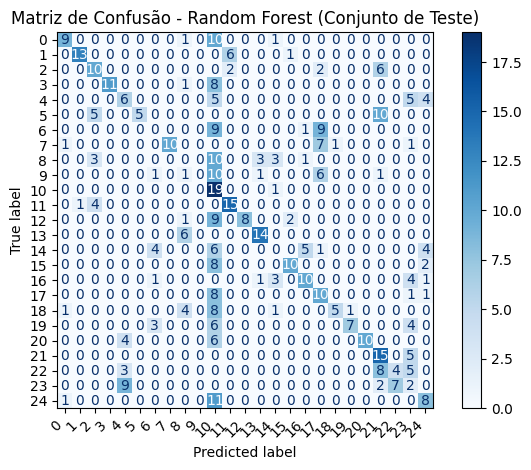


Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.75      0.43      0.55        21
           1       0.93      0.65      0.76        20
           2       0.45      0.50      0.48        20
           3       1.00      0.55      0.71        20
           4       0.27      0.30      0.29        20
           5       1.00      0.25      0.40        20
           6       0.00      0.00      0.00        19
           7       1.00      0.50      0.67        20
           8       0.00      0.00      0.00        20
           9       0.00      0.00      0.00        20
          10       0.14      0.95      0.25        20
          11       0.65      0.75      0.70        20
          12       1.00      0.40      0.57        20
          13       0.74      0.70      0.72        20
          14       0.00      0.00      0.00        20
          15       0.77      0.50      0.61        20
          16       0.59      0.50      0.54        2

/Users/felipelima/ml-projeto/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/felipelima/ml-projeto/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/felipelima/ml-projeto/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

In [157]:



# Calcular a matriz de confusão
cm = confusion_matrix(y_test, y_pred)

# Plotar a matriz de confusão
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title('Matriz de Confusão - Random Forest (Conjunto de Teste)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Exibir relatório de classificação detalhado
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred))


In [38]:
print("\n--- Targets ---")
print("y_train:", y_train.shape, y_train.dtype)
print("y_test:", y_test.shape, y_test.dtype)

print("\n--- Features Treino ---")
X_train.info()

print("\n--- Features Teste ---")
X_test.info()


--- Targets ---
y_train: (1988,) int64
y_test: (500,) int64

--- Features Treino ---
<class 'pandas.core.frame.DataFrame'>
Index: 1988 entries, 0 to 2500
Columns: 300 entries, id_0_x_mean to id_24_z_max
dtypes: float64(300)
memory usage: 4.6 MB

--- Features Teste ---
<class 'pandas.core.frame.DataFrame'>
Index: 500 entries, 501 to 1500
Columns: 300 entries, id_0_x_mean to id_24_z_max
dtypes: float64(300)
memory usage: 1.1 MB


## Modelagem e Avaliação (CV Estratificada)

Treinaremos e avaliaremos:
- Random Forest
- KNN
- MLP

Usaremos F1 macro e exibiremos a matriz de confusão a partir de `cross_val_predict` para cada modelo.


In [ ]:
# def avaliar_modelo(nome, estimator):
#     pipe = Pipeline(steps=[('preprocess', preprocess), ('model', estimator)])
#     # cross_validate para f1 macro
#     cv_results = cross_validate(
#         pipe, X, y, cv=cv, scoring=scorer, n_jobs=N_JOBS, return_estimator=False, error_score='raise'
#     )

#     # cross_val_predict para matriz de confusão
#     y_pred = cross_val_predict(pipe, X, y, cv=cv, n_jobs=N_JOBS, method='predict')

#     f1_mean = np.mean(cv_results['test_f1_macro'])
#     f1_std = np.std(cv_results['test_f1_macro'])

#     print(f"\nModelo: {nome}")
#     print(f"F1-macro (média ± std): {f1_mean:.4f} ± {f1_std:.4f}")

#     cm = confusion_matrix(y, y_pred)
#     disp = ConfusionMatrixDisplay(confusion_matrix=cm)
#     disp.plot(cmap='Blues', values_format='d')
#     plt.title(f'Matriz de Confusão - {nome}')
#     plt.show()

# # Modelos com hiperparâmetros básicos e random_state fixo
# rf = RandomForestClassifier(n_estimators=300, random_state=RANDOM_STATE, n_jobs=N_JOBS)
# knn = KNeighborsClassifier(n_neighbors=5, weights='distance')
# mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=RANDOM_STATE)

# for nome, est in [
#     ('Random Forest', rf),
#     ('KNN', knn),
#     ('MLP', mlp)
# ]:
#     avaliar_modelo(nome, est)
